<a href="https://colab.research.google.com/github/ForThisPlayer10/neural/blob/main/jupyter/simple_mnist_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

In [60]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

## Convert MNIST image files into 4D tensors (number of images, height, width, color channel)

In [61]:
transform = transforms.ToTensor()

In [62]:
train_data = datasets.MNIST(root='./simple-mnist-cnn_data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./simple-mnist-cnn_data', train=False, download=True, transform=transform)

## Understanding how model works

In [63]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [64]:
# input, output, kernel, stride
conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=6, stride=1)
conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)

In [65]:
for i, (X_Train, y_train) in enumerate (train_data):
  break

In [66]:
x = X_Train.view(1,1,28,28)

In [67]:
# first convolution
x = F.relu(conv1(x))

# 1 single image, 6 filters, 26x26 image
x.shape

torch.Size([1, 6, 23, 23])

In [68]:
# first pooling layer
x = F.max_pool2d(x, 2,2) # kernel 2, stride 2
# 26 / 2 = 13
x.shape

torch.Size([1, 6, 11, 11])

In [69]:
# second convolution
x = F.relu(conv2(x))
x.shape

torch.Size([1, 16, 9, 9])

In [70]:
# second pooling
x = F.max_pool2d(x, 2, 2)
# 11 / 2 = 5.5
x.shape

torch.Size([1, 16, 4, 4])

## Buildig out the model

In [71]:
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3, 1)
    self.fc1 = nn.Linear(5*5*16, 120) # 5x5 image size, 16 filters
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10) # 10 = number of classes in this dataset

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)

    # Flattening data out
    x = x.view(-1, 16*5*5)

    # Fully connected layers
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return F.log_softmax(x, dim=1)

In [72]:
torch.manual_seed(41)
model = ConvolutionalNetwork()

In [73]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # smaller lr -> longer train

## Training and testing model

In [74]:
import time
start_time = time.time()

In [75]:
# Tracking variables
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

In [76]:
# Training
for i in range(epochs):
  train_corr = 0
  test_corr = 0

  for b, (X_train, y_train) in enumerate(train_loader):
    # prediction
    b += 1
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    # verify predictions
    predicted = torch.max(y_pred.data, 1)[1]
    batch_corr = (predicted == y_train).sum()
    train_corr += batch_corr

    # update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if b%600 == 0:
      print(f'Epoch: {i}, batch: {b}, loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(train_corr)

  # Testing
  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1]
      test_corr += (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(test_corr)


Epoch: 0, batch: 600, loss: 0.1623610556125641
Epoch: 0, batch: 1200, loss: 0.1502392590045929
Epoch: 0, batch: 1800, loss: 0.4744560718536377
Epoch: 0, batch: 2400, loss: 0.14238706231117249
Epoch: 0, batch: 3000, loss: 0.007758188061416149
Epoch: 0, batch: 3600, loss: 0.3836284875869751
Epoch: 0, batch: 4200, loss: 0.0038223876617848873
Epoch: 0, batch: 4800, loss: 0.0021286322735249996
Epoch: 0, batch: 5400, loss: 0.0569545142352581
Epoch: 0, batch: 6000, loss: 0.00038789428072050214
Epoch: 1, batch: 600, loss: 0.005851339548826218
Epoch: 1, batch: 1200, loss: 0.3855525553226471
Epoch: 1, batch: 1800, loss: 0.004819948226213455
Epoch: 1, batch: 2400, loss: 0.003216963727027178
Epoch: 1, batch: 3000, loss: 0.0332382395863533
Epoch: 1, batch: 3600, loss: 0.5372857451438904
Epoch: 1, batch: 4200, loss: 0.04561494290828705
Epoch: 1, batch: 4800, loss: 0.0007510822033509612
Epoch: 1, batch: 5400, loss: 0.0001173773780465126
Epoch: 1, batch: 6000, loss: 0.14201366901397705
Epoch: 2, batch

In [77]:
current_time = time.time()
print(f'Total train time: {(current_time - start_time) / 60}')

Total train time: 4.004910739262899


## Graphing

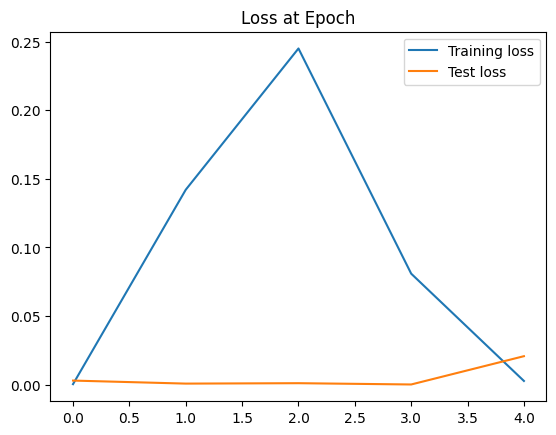

In [78]:
# Graph loss
train_losses = [ti.item() for ti in train_losses]
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Test loss")
plt.title("Loss at Epoch")
plt.legend()

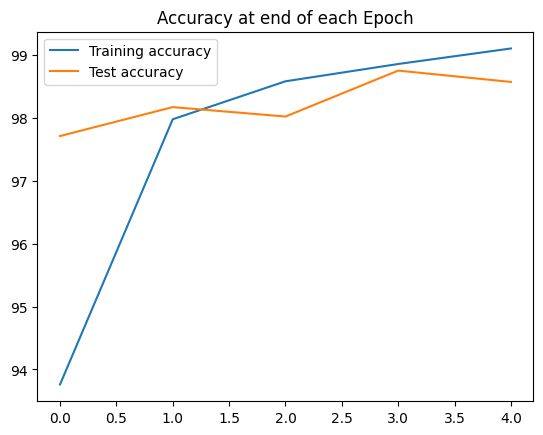

In [81]:
# Graph accuracy
plt.plot([t/600 for t in train_correct], label="Training accuracy")
plt.plot([t/100 for t in test_correct], label="Test accuracy")
plt.title("Accuracy at end of each Epoch")
plt.legend()

In [84]:
# Testing overall correctness
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [86]:
correct.item() / len(test_data)

0.9857

## Feeding new image through network

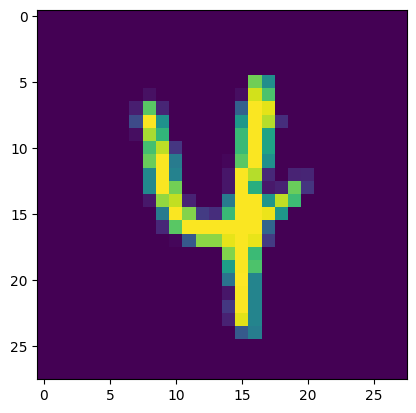

In [99]:
plt.imshow(test_data[3123][0].reshape(28,28))

In [98]:
model.eval()
with torch.no_grad():
  prediction = model(test_data[3123][0].view(1,1,28,28)) # batch size 1, 1 color channel, 28x28 image
prediction.argmax()

tensor(4)

## Saving model

In [100]:
torch.save(model.state_dict(), 'simple-mnist-cnn.pt')